## Outbound email spam detection using Unsupervised ML

**Objective**: To develop an unsupervised machine learning system capable of detecting anomalous outbound emails that may be classified as spam, by identifying patterns and deviations in email features.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest


In [2]:
#loading the data
df = pd.read_csv('MailCountLog.csv')

In [3]:
df.head(5)

,TimeStamp,EntityId,MachineName,TenantId,UserId,EmailAddress,DisplayName,ClientIP,ClientType,Country,...,MinutesFromCountryLastSeenToNow,ThirtyDayRcptAvg,ThirtyEntriesRcptAvg,FifteenEntriesRcptAvg,BlockedForToday,FPRate_COMP,FPRate_COMP_vNext,CustomData,Error,__date
0,12/4/2019 13:14,0de16bb3-94aa-4f54-e4f6-08d778bbe2b6,CH2PR04MB6572,edd56ed8-70ca-4351-83cb-4128876592e9,00000483-de56-414f-97d1-b72b620f8c58,PII:H101(MjgJopkn0lXCzsXT6LPZa/aCEGeCi1Sy/SzMJ...,NaN,170.76.157.18,MoMT,US,...,8,8,14,15,0,10000,NaN,NaN,NaN,12/4/2019 0:00
1,12/4/2019 16:25,dd6c22e5-cb71-486a-ee5c-08d778d695c4,BY5PR05MB6916,7d700ef5-a0c9-432a-a2ca-fc29c16f2d00,000004cd-3689-463a-ba8e-36372e58773f,PII:H101(v26ko9EwhcEK5hVGwwR836bLdfmvRE52a651R...,NaN,207.61.138.2,MoMT,CA,...,8,22,30,33,0,10000,NaN,NaN,NaN,12/4/2019 0:00
2,12/4/2019 11:05,86214b1b-2642-4cd7-fad5-08d778a9f148,VI1P193MB0448,de1535eb-16df-4359-90f1-75da64631829,00000f41-9298-4367-b8e4-b75332d537db,PII:H101(ztFxCJGhSYDTiPEcBSxRn2YkkMt2V45YaDKOg...,NaN,41.82.204.130,MoMT,SN,...,2861,4,6,8,0,10000,NaN,NaN,NaN,12/4/2019 0:00
3,12/4/2019 15:55,61eb22b4-4abb-43de-a5f4-08d778d25b73,BN6PR03MB3346,d13a3cbd-e4ce-45e1-91c2-98859a236439,00001702-e253-4739-b720-b55502131ba7,>,NaN,170.138.104.250,MoMT,US,...,0,8,17,12,0,10000,NaN,NaN,NaN,12/4/2019 0:00
4,12/4/2019 13:02,576066b2-f3b5-447b-2936-08d778ba28c9,AM6PR08MB3317,aa3c372d-0013-4bdc-b272-204afc0088b6,00001e01-7559-4f4c-9fc1-7076769d0c77,PII:H101(INn8+kyxBniSNBkiX9cTjsPpTviZ4Iqcv5Dr4...,NaN,89.38.121.125,MoMT,GB,...,1,39,47,47,0,10000,NaN,NaN,NaN,12/4/2019 0:00


In [4]:
#checking the shape
df.shape

(10000, 114)

In [5]:
#information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 114 entries, TimeStamp to __date
dtypes: float64(6), int64(95), object(13)
memory usage: 8.7+ MB


In [6]:
#statistical summary of the dataset
df.describe()

,DisplayName,TenantAgeInDays,AccountAgeInDays,TrialSeatCount,PaidSeatCount,TodayRcptCount,TodayExtRcptCount,TodaySpamRcptCount,TodaySpamRcptCount_Outbound,TodaySpamRcptCount_Inbound,...,MinutesFromCountryFirstSeenToNow,MinutesFromCountryLastSeenToNow,ThirtyDayRcptAvg,ThirtyEntriesRcptAvg,FifteenEntriesRcptAvg,BlockedForToday,FPRate_COMP,FPRate_COMP_vNext,CustomData,Error
count,0.0,10000.00000,10000.000000,371.000000,8.460000e+03,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,0.0,0.0,0.0
mean,NaN,1609.75810,836.012500,27651.269542,4.983989e+04,151.907600,73.224900,0.310400,0.286900,0.023500,...,7.086020e+07,7.071963e+07,152.773100,227.948500,234.604200,0.000400,8384.621400,NaN,NaN,NaN
std,NaN,843.61535,675.196099,113199.411144,1.835058e+05,694.684053,446.028936,3.967673,3.927204,0.536075,...,2.647248e+08,2.647623e+08,569.986641,945.305662,961.280083,0.019997,3522.889912,NaN,NaN,NaN
min,NaN,0.00000,0.000000,5.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,1036.00000,306.000000,25.000000,1.870000e+02,5.000000,0.000000,0.000000,0.000000,0.000000,...,1.640972e+05,2.000000e+00,12.000000,18.000000,17.000000,0.000000,10000.000000,NaN,NaN,NaN
50%,NaN,1735.50000,669.000000,25.000000,2.748500e+03,17.000000,2.000000,0.000000,0.000000,0.000000,...,1.686030e+05,1.100000e+01,27.000000,36.000000,35.000000,0.000000,10000.000000,NaN,NaN,NaN
75%,NaN,2223.00000,1210.000000,75.000000,2.807550e+04,47.000000,11.000000,0.000000,0.000000,0.000000,...,1.689300e+05,8.400000e+01,55.000000,71.000000,71.000000,0.000000,10000.000000,NaN,NaN,NaN
max,NaN,4237.00000,3237.000000,501000.000000,2.393043e+06,10069.000000,7858.000000,126.000000,126.000000,25.000000,...,1.061852e+09,1.061852e+09,5746.000000,10293.000000,10293.000000,1.000000,10000.000000,NaN,NaN,NaN


<b>Data Cleaning</b>

In [7]:
#checking for nulls
df.isna().sum()

TimeStamp                0
EntityId                 0
MachineName              0
TenantId                 0
UserId                   0
                     ...  
FPRate_COMP              0
FPRate_COMP_vNext    10000
CustomData           10000
Error                10000
__date                   0
Length: 114, dtype: int64

In [8]:
#print the percentage of the missing values
summary = pd.DataFrame({'missing_count': df.isna().sum(),
                        'missing_percent': df.isna().mean()*100}).sort_values(by='missing_percent', ascending=False)
summary


,missing_count,missing_percent
Error,10000,100.00
CustomData,10000,100.00
FPRate_COMP_vNext,10000,100.00
DisplayName,10000,100.00
TrialSeatCount,9629,96.29
...,...,...
Last1HrIntraSpamMsgCount,0,0.00
Last1HrSpamMsgCount,0,0.00
Last1HrTotalRcptCount,0,0.00
Last1HrMsgCount,0,0.00


In [9]:
# Drop empty columns
drop_cols = summary[(summary['missing_percent'] >= 90)].index.tolist()

# Drop known IDs
drop_cols += ["EntityId","MachineName","TenantId","UserId","EmailAddress","ClientIP", "__date"]

df_dropped = df.drop(columns=drop_cols, errors="ignore")
df_dropped

,TimeStamp,ClientType,Country,RecipientType,MailboxCreationDate,TenantAgeInDays,AccountAgeInDays,IsTrialTenant,PaidSeatCount,TodayRcptCount,...,MinutesFromClientTypeLastSeenToNow,MinutesFromSenderDomainFirstSeenToNow,MinutesFromSenderDomainLastSeenToNow,MinutesFromCountryFirstSeenToNow,MinutesFromCountryLastSeenToNow,ThirtyDayRcptAvg,ThirtyEntriesRcptAvg,FifteenEntriesRcptAvg,BlockedForToday,FPRate_COMP
0,12/4/2019 13:14,MoMT,US,UserMailbox,7/2/2012 16:36,2710,2710,False,6.0,14,...,8,321198,8,168515,8,8,14,15,0,10000
1,12/4/2019 16:25,MoMT,CA,UserMailbox,2/23/2017 7:56,2197,1014,False,NaN,9,...,8,305446,8,164356,8,22,30,33,0,10000
2,12/4/2019 11:05,MoMT,SN,UserMailbox,9/26/2018 5:08,969,433,False,152.0,0,...,2861,321110,2861,160045,2861,4,6,8,0,10000
3,12/4/2019 15:55,MoMT,US,UserMailbox,7/19/2019 14:36,2467,137,False,27625.0,6,...,0,1061851195,1061851195,168332,0,8,17,12,0,10000
4,12/4/2019 13:02,MoMT,GB,UserMailbox,4/9/2015 1:51,2016,1700,False,533.0,18,...,1,321458,1,168831,1,39,47,47,0,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12/4/2019 6:39,OWA,IN,UserMailbox,2/2/2017 4:56,2985,1034,False,25163.0,2,...,33,321215,33,164199,33,7,9,9,0,10000
9996,12/4/2019 1:22,MoMT,US,UserMailbox,7/11/2016 12:56,1657,1240,False,19180.0,9,...,5,321293,5,161823,5,19,25,26,0,10000
9997,12/4/2019 17:52,MoMT,US,UserMailbox,7/11/2016 12:56,1657,1240,False,19180.0,23,...,9,322283,9,162813,9,20,26,27,0,10000
9998,12/4/2019 21:21,MoMT,FR,UserMailbox,7/12/2018 12:59,1829,510,False,22300.0,125,...,2,321386,2,2033,2,115,115,93,0,10000


In [10]:
#check for the remaining nulls
col_summary = pd.DataFrame({
    "missing_count": df_dropped.isnull().sum(),
    "missing_percent": df_dropped.isnull().mean() * 100,
}).sort_values(by="missing_percent", ascending=False)

col_summary.head(10)  


,missing_count,missing_percent
PaidSeatCount,1540,15.40
IsTrialTenant,809,8.09
Country,658,6.58
TimeStamp,0,0.00
Last30DaySpamMsgCount,0,0.00
Last60DayIntraSpamMsgCount,0,0.00
Last60DaySpamMsgCount,0,0.00
Last60DayTotalRcptCount,0,0.00
Last60DayMsgCount,0,0.00
Last60DaySpamRcptCount_Inbound,0,0.00


In [11]:
#fill in columns with few nulls
df_dropped = df_dropped.fillna({
    'PaidSeatCount': df_dropped['PaidSeatCount']. median(),
    'IsTrialTenant': df_dropped['IsTrialTenant']. mode()[0],
    'Country': 'Unknown'
})

In [12]:
#convert the date to datetime data type
df_dropped['TimeStamp'] = pd.to_datetime(df_dropped['TimeStamp'], errors='coerce')
df_dropped['MailboxCreationDate'] = pd.to_datetime(df_dropped['MailboxCreationDate'], errors='coerce')

df_dropped['Hours'] = df_dropped['TimeStamp'].dt.hour
df_dropped['Month']= df_dropped['TimeStamp'].dt.month
df_dropped['Day'] = df_dropped['TimeStamp'].dt.day
df_dropped['Year'] = df_dropped['TimeStamp'].dt.year
df_dropped['Minute'] = df_dropped['TimeStamp'].dt.minute

#get number of days the account has been since it's creation
df_dropped['AccountAgeDays'] = (df_dropped['TimeStamp'] - df_dropped['MailboxCreationDate']).dt.days

#drop columns
df_dropped = df_dropped.drop(columns=['TimeStamp','MailboxCreationDate'], axis=1)


In [13]:
#frequency encoding for the country colum
country_freq =  df_dropped['Country'].value_counts()
df_dropped['Country'] = df_dropped['Country'].map(country_freq)

In [14]:
df_dropped['RecipientType'] = df_dropped['RecipientType'].map({
    'UserMailbox': 0,
    'MailUniversalDistributionGroup':1
})

In [15]:
encoder = LabelEncoder()
df_dropped['ClientType'] = encoder.fit_transform(df_dropped['ClientType'])

<b>Feature Selection</b>

In [16]:
#drop columns with low variance
selector = VarianceThreshold(threshold=0.01)  
df_selected = selector.fit_transform(df_dropped)
selected_columns = df_dropped.columns[selector.get_support()]
df_selected = pd.DataFrame(df_selected, columns=selected_columns)
df_selected

,ClientType,Country,TenantAgeInDays,AccountAgeInDays,PaidSeatCount,TodayRcptCount,TodayExtRcptCount,TodaySpamRcptCount,TodaySpamRcptCount_Outbound,TodaySpamRcptCount_Inbound,...,MinutesFromSenderDomainLastSeenToNow,MinutesFromCountryFirstSeenToNow,MinutesFromCountryLastSeenToNow,ThirtyDayRcptAvg,ThirtyEntriesRcptAvg,FifteenEntriesRcptAvg,FPRate_COMP,Hours,Minute,AccountAgeDays
0,1.0,3528.0,2710.0,2710.0,6.0,14.0,11.0,0.0,0.0,0.0,...,8.000000e+00,1.685150e+05,8.000000e+00,8.0,14.0,15.0,10000.0,13.0,14.0,2710.0
1,1.0,343.0,2197.0,1014.0,2748.5,9.0,2.0,0.0,0.0,0.0,...,8.000000e+00,1.643560e+05,8.000000e+00,22.0,30.0,33.0,10000.0,16.0,25.0,1014.0
2,1.0,3.0,969.0,433.0,152.0,0.0,0.0,0.0,0.0,0.0,...,2.861000e+03,1.600450e+05,2.861000e+03,4.0,6.0,8.0,10000.0,11.0,5.0,434.0
3,1.0,3528.0,2467.0,137.0,27625.0,6.0,0.0,0.0,0.0,0.0,...,1.061851e+09,1.683320e+05,0.000000e+00,8.0,17.0,12.0,10000.0,15.0,55.0,138.0
4,1.0,837.0,2016.0,1700.0,533.0,18.0,3.0,0.0,0.0,0.0,...,1.000000e+00,1.688310e+05,1.000000e+00,39.0,47.0,47.0,10000.0,13.0,2.0,1700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,330.0,2985.0,1034.0,25163.0,2.0,0.0,0.0,0.0,0.0,...,3.300000e+01,1.641990e+05,3.300000e+01,7.0,9.0,9.0,10000.0,6.0,39.0,1035.0
9996,1.0,3528.0,1657.0,1240.0,19180.0,9.0,0.0,0.0,0.0,0.0,...,5.000000e+00,1.618230e+05,5.000000e+00,19.0,25.0,26.0,10000.0,1.0,22.0,1240.0
9997,1.0,3528.0,1657.0,1240.0,19180.0,23.0,4.0,0.0,0.0,0.0,...,9.000000e+00,1.628130e+05,9.000000e+00,20.0,26.0,27.0,10000.0,17.0,52.0,1241.0
9998,1.0,320.0,1829.0,510.0,22300.0,125.0,68.0,0.0,0.0,0.0,...,2.000000e+00,2.033000e+03,2.000000e+00,115.0,115.0,93.0,10000.0,21.0,21.0,510.0


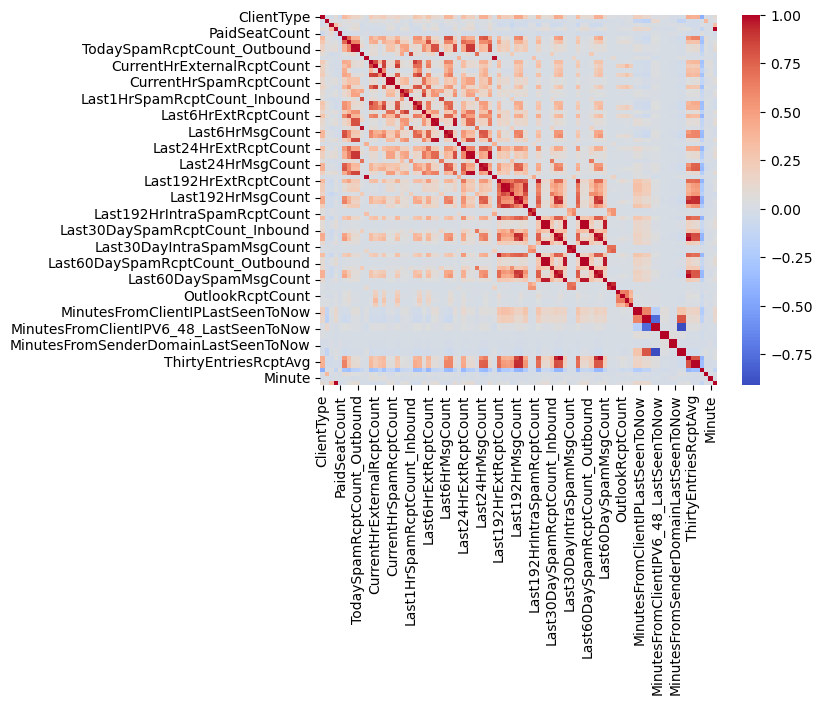

In [17]:
#handle multicollinearity
corr_matrix = df_selected.corr()


sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

In [18]:
#handle multicollinearity
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_selected = df_selected.drop(columns=to_drop)

In [19]:
#scale data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

#dimensionality reduction
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)

In [20]:
df_pca

array([[-0.69656563,  0.03488561, -0.62963256, ...,  0.77176168,
        -0.0979841 , -0.0056746 ],
       [-0.75976732, -0.17547348, -0.40074905, ..., -0.31820651,
         0.03244915, -1.15436283],
       [-0.90808995, -0.02526627, -0.29095137, ..., -0.0177729 ,
        -0.02070208,  0.06901523],
       ...,
       [-0.71219636, -0.18288571, -0.56790346, ...,  0.41144573,
        -0.13542628, -0.07522614],
       [-0.64532293, -0.09976179, -0.39896034, ..., -0.60274813,
         0.04760382,  0.00348443],
       [-0.80001331,  0.98869977,  2.09778408, ...,  0.45875613,
         0.63833859, -0.00440459]])

<b>Modelling</b>

<i>KMEANS</i>

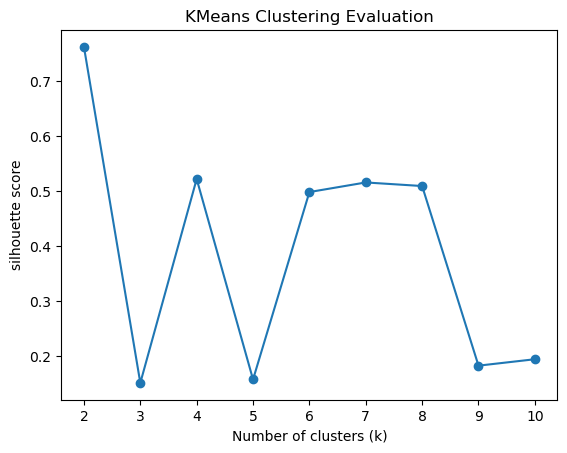

In [21]:
#KMEANS
silhouette_scores = []
K = range(2,11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_pca)
    silhouette_scores.append(silhouette_score(df_pca, labels))
#plot
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("silhouette score")
plt.title("KMeans Clustering Evaluation")
plt.show()

In [22]:
best_k = 2
kmeans = KMeans(n_clusters=best_k, random_state=42)
results = kmeans.fit_predict(df_pca)

df_clusters = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
df_clusters['Cluster'] = results

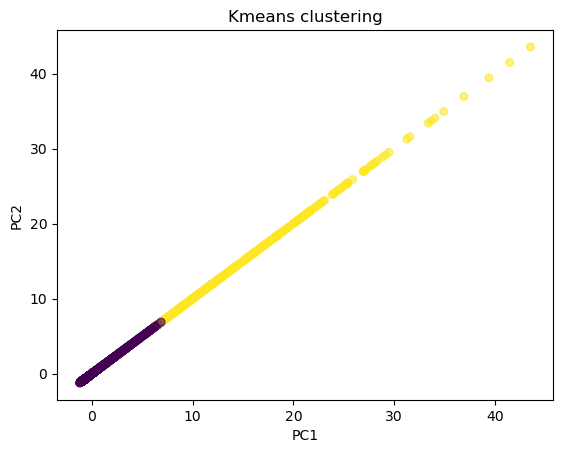

In [23]:
plt.scatter(df_clusters['PC1'],df_clusters['PC1'], c=df_clusters['Cluster'], cmap='viridis',s=30, alpha=0.6)
plt.title("Kmeans clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [28]:
df_clusters

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC24,PC25,PC26,PC27,PC28,PC29,PC30,Cluster,DBSCAN,IForest
0,-0.696566,0.034886,-0.629633,-0.044826,-0.067617,0.192289,-0.376390,0.003122,0.063954,-1.164740,...,-0.995431,0.369137,-0.447171,0.196156,0.771762,-0.097984,-0.005675,0,0,1
1,-0.759767,-0.175473,-0.400749,0.525040,0.242593,0.024940,-0.758216,-0.141185,0.006080,0.081068,...,0.548597,0.255711,0.310975,0.049396,-0.318207,0.032449,-1.154363,0,0,1
2,-0.908090,-0.025266,-0.290951,0.087083,-0.358304,-0.075018,-0.236600,0.065620,-0.051360,0.570781,...,0.183485,0.397383,0.140488,0.040925,-0.017773,-0.020702,0.069015,0,0,1
3,-0.925220,-0.195298,-0.712760,0.086500,-0.591459,-0.105987,-0.351212,0.250212,0.082048,-0.416604,...,0.356228,-0.800758,-0.149710,-0.178712,0.812346,0.463531,-0.126776,0,1,-1
4,-0.777310,0.032308,-0.417622,-0.007837,-0.142919,-0.045136,-0.278042,0.011088,0.075480,-0.136096,...,-0.113170,0.706992,0.077338,0.165141,0.214072,-0.071096,0.050089,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.781975,0.051410,-0.365077,-0.073930,-0.166522,0.000148,-0.228189,0.173601,0.009925,0.392713,...,0.261444,-0.821159,0.231389,0.059335,-0.105788,0.512493,0.025457,0,0,1
9996,-0.792173,-0.055307,-0.498326,-0.008733,-0.395526,-0.057294,-0.383346,0.140911,-0.001542,0.072218,...,-1.481038,-0.909958,-0.930834,-0.078995,0.947399,-0.038484,-0.008299,0,0,1
9997,-0.712196,-0.182886,-0.567903,0.069811,-0.395380,-0.080252,-0.254511,0.049619,0.007049,-0.863505,...,-0.382219,0.028821,-0.296188,-0.045904,0.411446,-0.135426,-0.075226,0,0,1
9998,-0.645323,-0.099762,-0.398960,0.006020,-0.302839,0.138654,-0.188175,-0.127439,-0.086658,-0.306478,...,1.032484,0.552839,0.521213,0.060541,-0.602748,0.047604,0.003484,0,0,1


<i>DBSCAN</i>

In [24]:
#DBSCAN (Density-Based Spatial Clustering)
dbscan = DBSCAN(eps=2, min_samples=5)
df_clusters['DBSCAN'] = dbscan.fit_predict(df_pca)

print(df_clusters['DBSCAN'].value_counts())

DBSCAN
 0     7377
-1      828
 3      815
 2      350
 7       93
 9       53
 16      51
 13      44
 10      43
 11      35
 8       28
 6       27
 27      26
 22      21
 19      20
 12      19
 4       17
 20      15
 26      15
 25      14
 15      13
 18      12
 30      12
 24      11
 28      10
 5       10
 21       9
 31       6
 14       6
 1        6
 23       5
 17       5
 29       4
Name: count, dtype: int64


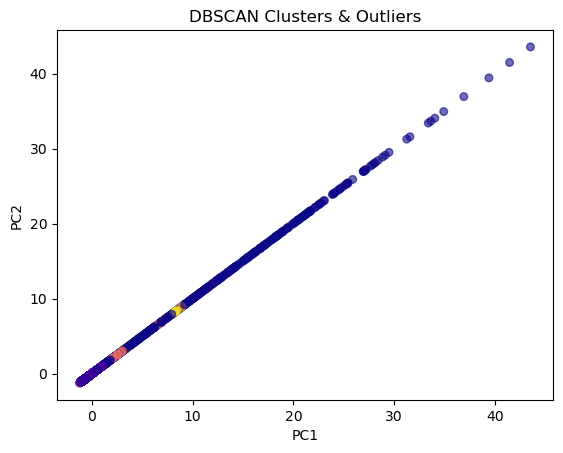

In [25]:
plt.scatter(df_clusters['PC1'],df_clusters['PC1'], c=df_clusters['DBSCAN'], cmap='plasma',s=30, alpha=0.6)
plt.title("DBSCAN Clusters & Outliers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [26]:
#isolation forest
iso = IsolationForest(contamination=0.05, random_state=42)
df_clusters['IForest'] = iso.fit_predict(df_pca)

df_clusters['IForest'].value_counts()

IForest
 1    9500
-1     500
Name: count, dtype: int64

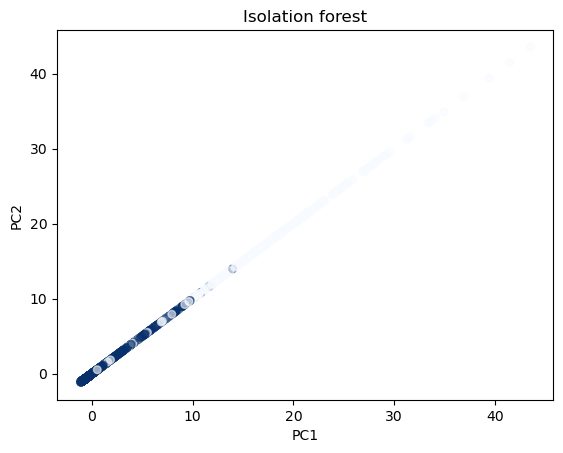

In [27]:
plt.scatter(df_clusters['PC1'],df_clusters['PC1'], c=df_clusters['IForest'], cmap='Blues',s=30, alpha=0.6)
plt.title("Isolation forest")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()